In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/give-me-some-credit-dataset/Data Dictionary.xls
/kaggle/input/give-me-some-credit-dataset/cs-training.csv
/kaggle/input/give-me-some-credit-dataset/sampleEntry.csv
/kaggle/input/give-me-some-credit-dataset/cs-test.csv


In [2]:
def plot_roc_curve(fpr, tpr, roc_auc, label="ROC Curve"):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
def plot_feature_importances(model, X):
    """
    Visualizes the importance of features in the model.

    Parameters:
    model (object): The trained model (e.g., LogisticRegression, DecisionTreeClassifier).
    X (pd.DataFrame or np.array): The data on which the model was trained.
    """
    if isinstance(model, LogisticRegression):
        coef = model.coef_[0]
        importance_attr = 'coef_'
    else:
        coef = model.feature_importances_
        importance_attr = 'feature_importances_'
    
    n_features = len(coef)

    feature_names = X.columns.tolist()

    sorted_indices = np.argsort(np.abs(coef))[::-1]
    sorted_coef = coef[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.barh(range(n_features), np.abs(sorted_coef), align='center', color='skyblue')
    plt.yticks(np.arange(n_features), sorted_feature_names, color='white')
    plt.xticks(color='black')
    plt.xlabel('Feature Importance', color='black')
    plt.ylabel('Feature', color='black')
    plt.ylim(-1, n_features)
    plt.grid(visible=True, which='major', color='gray', linestyle='--')
    title_obj = ax.set_title(f"Feature Importance for {type(model).__name__}")
    plt.setp(title_obj, color='b')
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    fig.tight_layout()
    plt.show()

In [4]:
train_df = pd.read_csv("/kaggle/input/give-me-some-credit-dataset/cs-training.csv")
test_df = pd.read_csv("/kaggle/input/give-me-some-credit-dataset/cs-test.csv")

<h3 style=color:blue>Descriptive Statistics</h3>

In [5]:
train_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
test_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [7]:
train_df.rename(columns={"Unnamed: 0": "ID"}, inplace=True)
test_df.rename(columns={"Unnamed: 0": "ID"}, inplace=True)

In [8]:
train_df.describe().round(decimals=2)

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,75000.50,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,43301.41,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,37500.75,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,75000.50,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,112500.25,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,150000.00,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


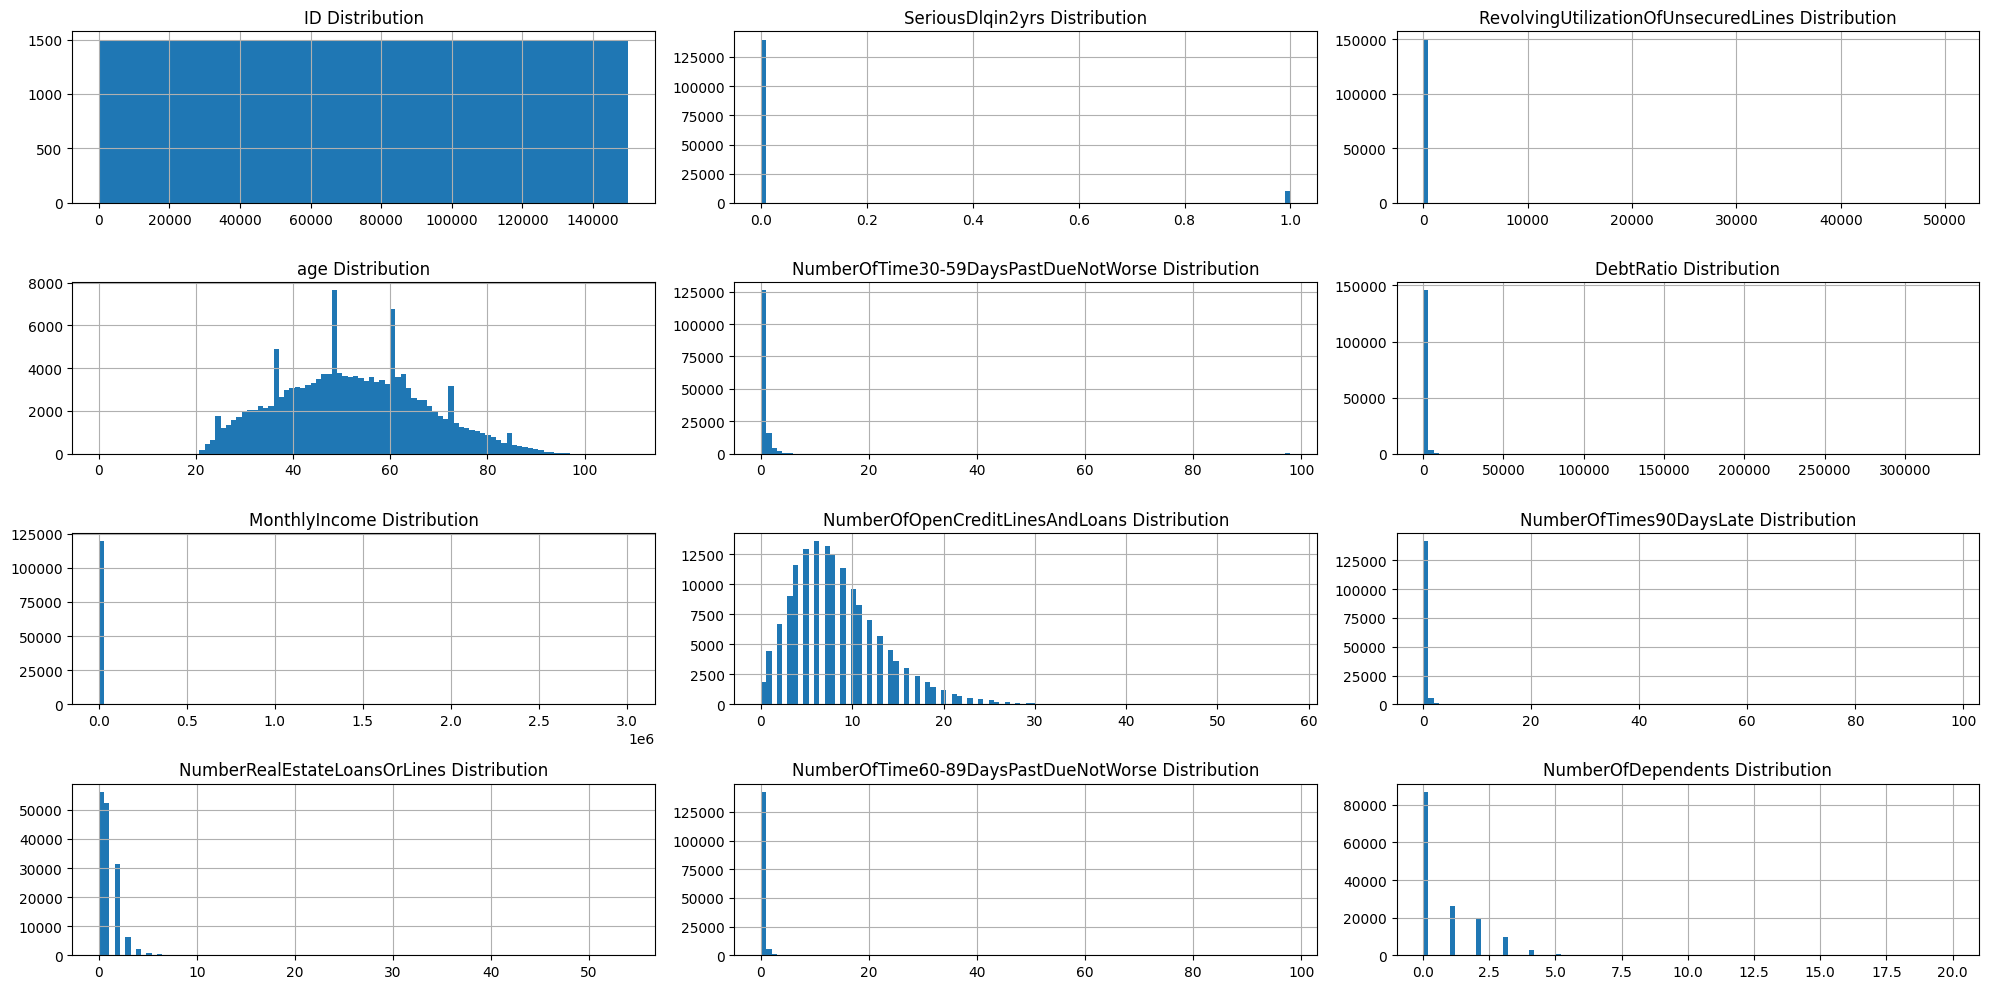

In [9]:
variables = train_df.columns

fig = plt.figure(figsize=(20, 10))
for i, var in enumerate(variables):
    ax = fig.add_subplot(4, 3, i+1)
    train_df[var].hist(bins=100, ax=ax)
    ax.set_title(f"{var} Distribution")

fig.tight_layout()
plt.show()

In [10]:
train_df.duplicated().value_counts()

False    150000
Name: count, dtype: int64

In [11]:
test_df.duplicated().value_counts()

False    101503
Name: count, dtype: int64

In [12]:
def missing_values_table(df):
    """
    Purpose: To examine a Pandas DataFrame and output the list of columns with missing data (NaN or blanks).
    Returns: DataFrame with two columns: 'Missing Values' and '% of Total Values'.
    """
    miss_val = df.isnull().sum()
    miss_val_percent = 100 * miss_val / df.shape[0]
    
    miss_val_table = pd.DataFrame({
        'Missing Values': miss_val,
        '% of Total Values': miss_val_percent
    })
    miss_val_table = miss_val_table[miss_val_table['Missing Values'] != 0].sort_values(
        by='% of Total Values', ascending=False).round(2)
    
    print(f"Your selected DataFrame has {df.shape[1]} columns.\n"
          f"There are {miss_val_table.shape[0]} columns that have missing values.")
    
    return miss_val_table

missing_values_table(train_df)


Your selected DataFrame has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
MonthlyIncome,29731,19.82
NumberOfDependents,3924,2.62


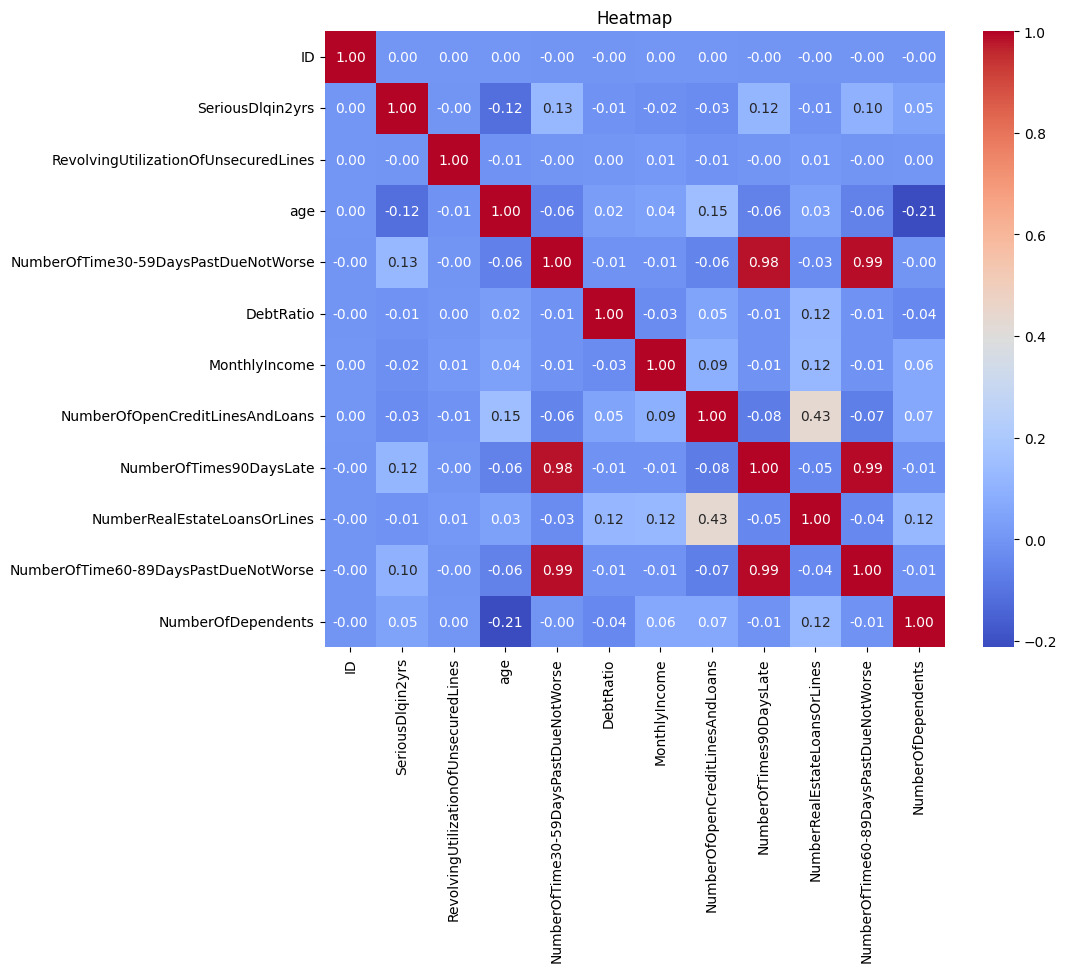

In [13]:
def plot_heatmap(df):
    corr_matrix = df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Heatmap")
    plt.show()

plot_heatmap(train_df)

<h3 style=color:blue>Examining the Features</h3>

<h4 style=color:red>SeriousDlqin2yrs</h4>

In [14]:
value_counts = train_df['SeriousDlqin2yrs'].value_counts()

total_count = train_df.shape[0]
count_NO = value_counts.loc[0]
count_YES = value_counts.loc[1]
percent_NO = value_counts.loc[0] / total_count
percent_YES = value_counts.loc[1] / total_count

result_df = pd.DataFrame({
    'SeriousDlqin2yrs': [0, 1],
    'Count': [count_NO, count_YES],
    'Percent': [percent_NO, percent_YES]
    
})

result_df['Percent'] = result_df['Percent'].apply(lambda x : f"{x:.2%}")
result_df

,SeriousDlqin2yrs,Count,Percent
0,0,139974,93.32%
1,1,10026,6.68%


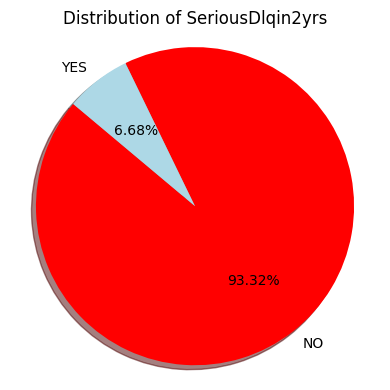

In [15]:
def plot_pie_chart(df, column):
    """
    Plot a pie chart for the specified column in the DataFrame with labels "NO" and "YES".
    """
    value_counts = df[column].value_counts()

    labels = 'NO', 'YES'
    colors = ['red', 'lightblue']
    # Plot the pie chart
    plt.figure(figsize=(4, 4))
    patches, texts, autotexts = plt.pie(value_counts, labels=labels, autopct='%1.2f%%',
                                        shadow=True, startangle=140, colors=colors)
    for text in texts:
        text.set_color('black')
    for autotext in autotexts:
        autotext.set_color('black')
    plt.axis('equal')
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

plot_pie_chart(train_df, "SeriousDlqin2yrs")

<h4 style=color:red>age</h4>

In [16]:
train_df.loc[train_df['age'] < 21]

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


<p style=color:red>There is one data point with an age value of zero. Resetting this value to the median.</p>

<h4 style=color:red>MonthlyIncome</h4>

In [17]:
train_df['MonthlyIncome'].value_counts().sort_index

<bound method Series.sort_index of MonthlyIncome
5000.0     2757
4000.0     2106
6000.0     1934
3000.0     1758
0.0        1634
           ... 
16084.0       1
10523.0       1
55250.0       1
9242.0        1
7647.0        1
Name: count, Length: 13594, dtype: int64>

In [18]:
train_df['MonthlyIncome'].isna().sum()

29731

<h4 style=color:red>NumberOfDependents</h4>

In [19]:
train_df['NumberOfDependents'].value_counts().sort_index()

NumberOfDependents
0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: count, dtype: int64

<h4 style=color:red>NumberOfTime30-59DaysPastDueNotWorse</h4>

In [20]:
train_df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts().sort_index()

NumberOfTime30-59DaysPastDueNotWorse
0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: count, dtype: int64

<h4 style=color:red>NumberOfTimes90DaysLate</h4>

In [21]:
train_df['NumberOfTimes90DaysLate'].value_counts().sort_index()

NumberOfTimes90DaysLate
0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: count, dtype: int64

<h4 style=color:red>NumberOfTime60-89DaysPastDueNotWorse</h4>

In [22]:
train_df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts().sort_index()

NumberOfTime60-89DaysPastDueNotWorse
0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: count, dtype: int64

In [23]:
def replaceSpuriousValues96and98(data):
    new_data = data.copy()
    median = new_data[(new_data != 96) & (new_data != 98)].median()
    new_data.loc[(new_data == 96) | (new_data == 98)] = median
    return new_data

train_df['NumberOfTime60-89DaysPastDueNotWorse'] = replaceSpuriousValues96and98(train_df['NumberOfTime60-89DaysPastDueNotWorse'])
train_df['NumberOfTimes90DaysLate'] = replaceSpuriousValues96and98(train_df['NumberOfTimes90DaysLate'])
train_df['NumberOfTime30-59DaysPastDueNotWorse'] = replaceSpuriousValues96and98(train_df['NumberOfTime30-59DaysPastDueNotWorse'])

In [24]:
selected_columns = ['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse']

for column in selected_columns:
    print(f"Statistics for column '{column}':")
    print(train_df[column].value_counts().sort_index())
    print("\n")

Statistics for column 'NumberOfTime60-89DaysPastDueNotWorse':
NumberOfTime60-89DaysPastDueNotWorse
0     142665
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
Name: count, dtype: int64


Statistics for column 'NumberOfTimes90DaysLate':
NumberOfTimes90DaysLate
0     141931
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
Name: count, dtype: int64


Statistics for column 'NumberOfTime30-59DaysPastDueNotWorse':
NumberOfTime30-59DaysPastDueNotWorse
0     126287
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
Name: count, dtype: int64




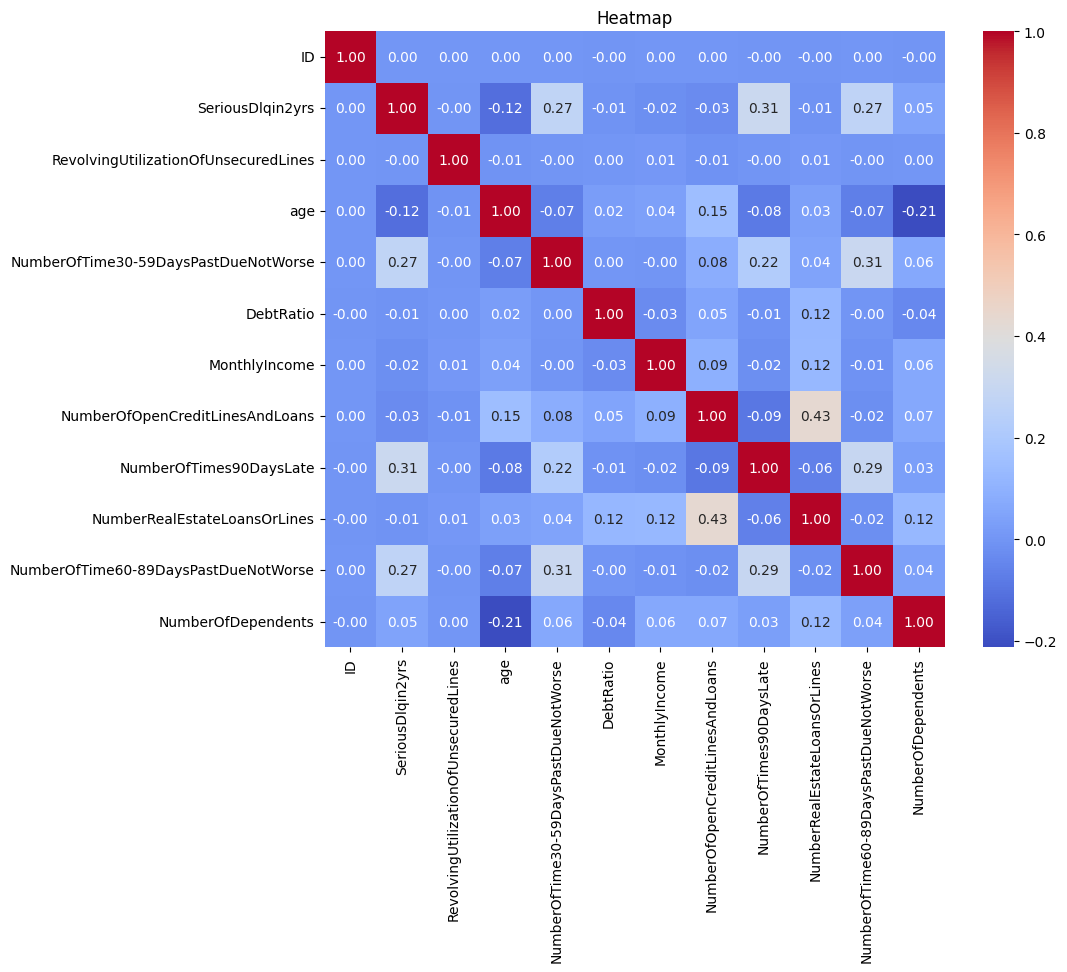

In [25]:
plot_heatmap(train_df)

<h3 style=color:red>Imputing</h3>

In [26]:
train_df.loc[train_df['age'] == 0, 'age'] = train_df['age'].median()
train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())

test_df.loc[test_df['age'] == 0, 'age'] = test_df['age'].median()
test_df['MonthlyIncome'] = test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].median())
test_df['MonthlyIncome'] = test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].median())

<h3 style=color:red>Model Training</h3>

In [27]:
X = train_df.drop(columns=['ID', 'SeriousDlqin2yrs'])
y = train_df['SeriousDlqin2yrs']

A = test_df.drop(columns=['ID', 'SeriousDlqin2yrs'])
b = test_df['SeriousDlqin2yrs']

<h4 style=color:red>Cross Validation - two splits- training, test</h4>

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h4 style=color:red>Logistic Regression</h4>

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics

# param_dist = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga'],
#     'class_weight': ['balanced', None],
#     'max_iter': [500],
#     'penalty': ['l1']
# }

#random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_dist, n_iter=24, cv=5, scoring='roc_auc', random_state=42)

#random_search.fit(X_train_scaled, y_train)

#print("Best parameters:", random_search.best_params_)
#Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'class_weight': 'balanced', 'C': 0.1}

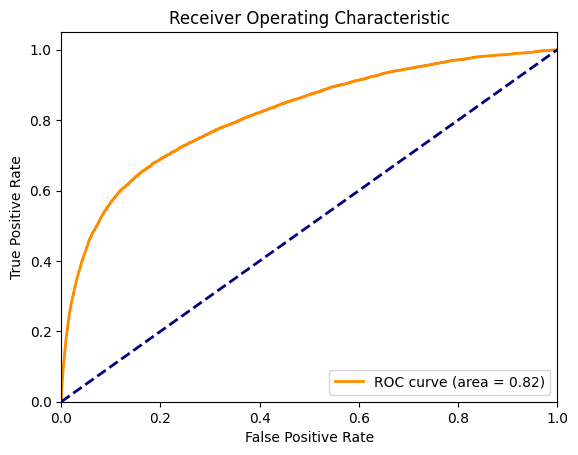

AUC Score: 0.8159635


In [30]:
clf = LogisticRegression(penalty='l1', C=0.1, class_weight='balanced', random_state=42, solver='liblinear', max_iter=500)

clf.fit(X_train_scaled, y_train)
preds = clf.predict_proba(X_train_scaled)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

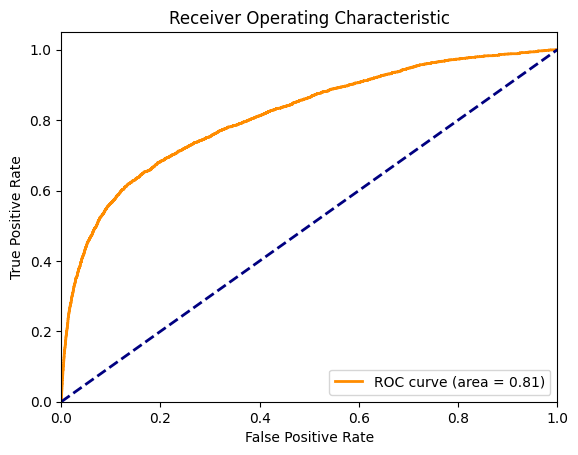

AUC Score: 0.8127497


In [31]:
preds = clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

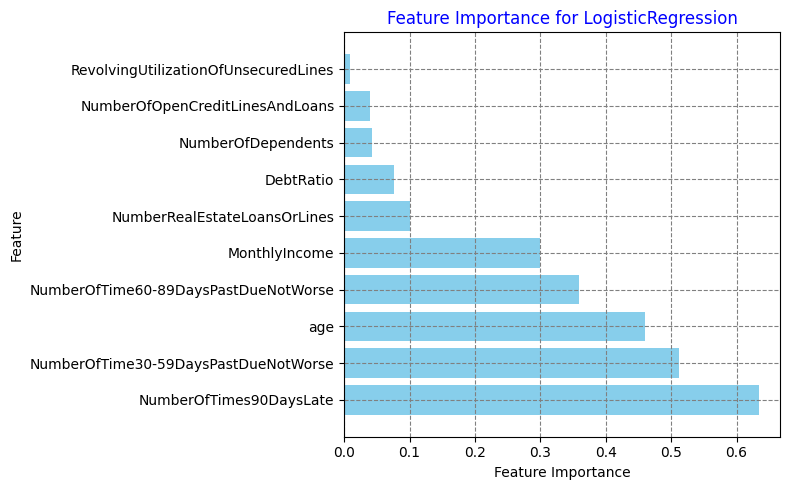

In [32]:
plot_feature_importances(clf, X_train)

<h4 style=color:red>Decision Tree</h4>

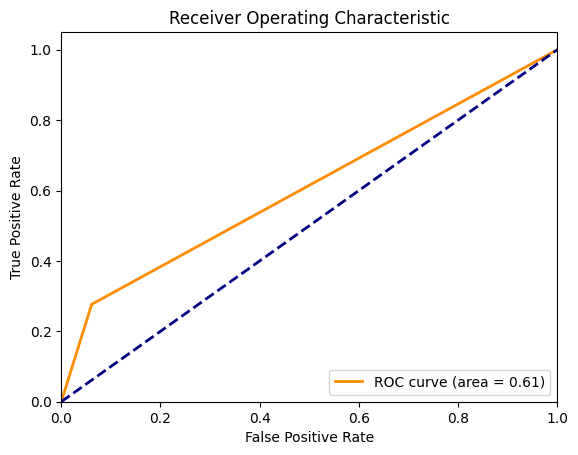

AUC Score: 0.6077254


In [33]:
from sklearn.tree import DecisionTreeClassifier
# Out-of-sample sample
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

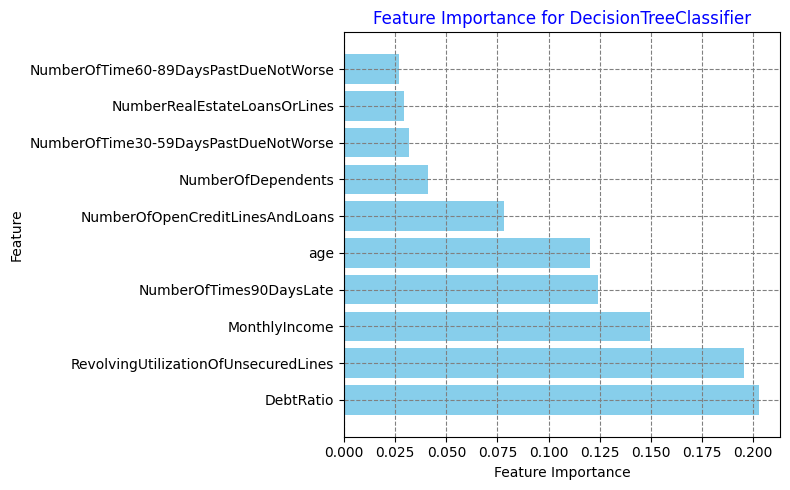

In [34]:
plot_feature_importances(clf, X_train)

<h4 style=color:red>Random Forest</h4>

In [35]:
from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 3, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False],
#     'class_weight': ['balanced', None]
# }

# clf = RandomForestClassifier(random_state=42)
# random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

# random_search.fit(X_train, y_train)

# print("Best parameters found: ", random_search.best_params_)

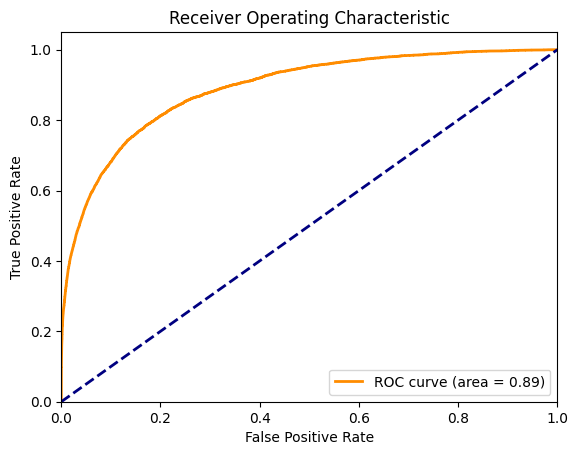

AUC Score: 0.8892008


In [36]:
clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=10, class_weight=None, bootstrap=True, random_state=42)
clf.fit(X_train_scaled, y_train)
preds = clf.predict_proba(X_train_scaled)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

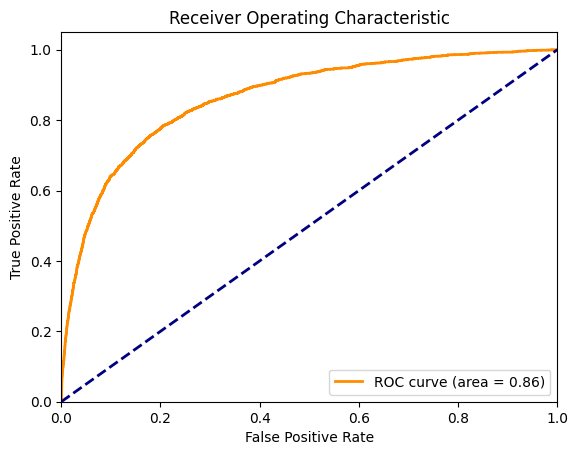

AUC Score: 0.8639528


In [37]:
preds = clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

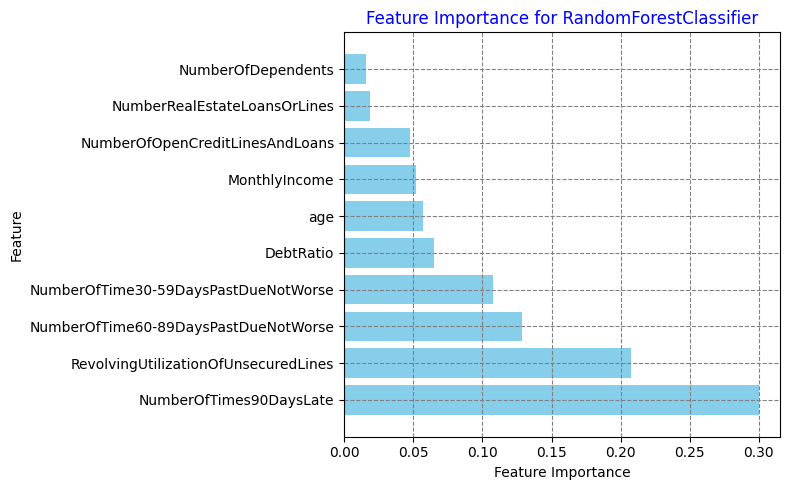

In [38]:
plot_feature_importances(clf, X_train)

<h4 style=color:red>Gradient Boosting</h4>

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
# }

# gb = GradientBoostingClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# Best parameters found:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}

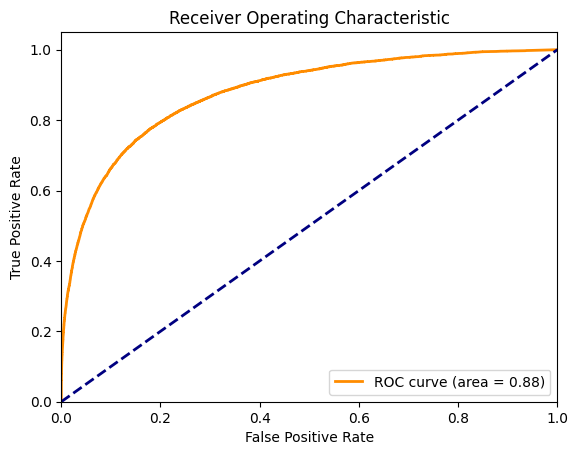

AUC Score: 0.8778998


In [40]:
clf = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_train)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

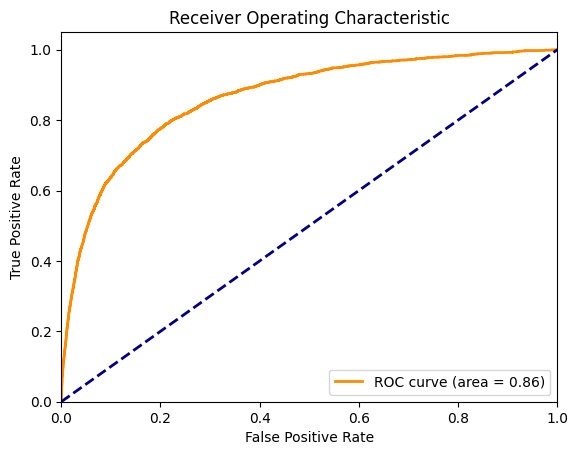

AUC Score: 0.8644527


In [41]:
preds = clf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

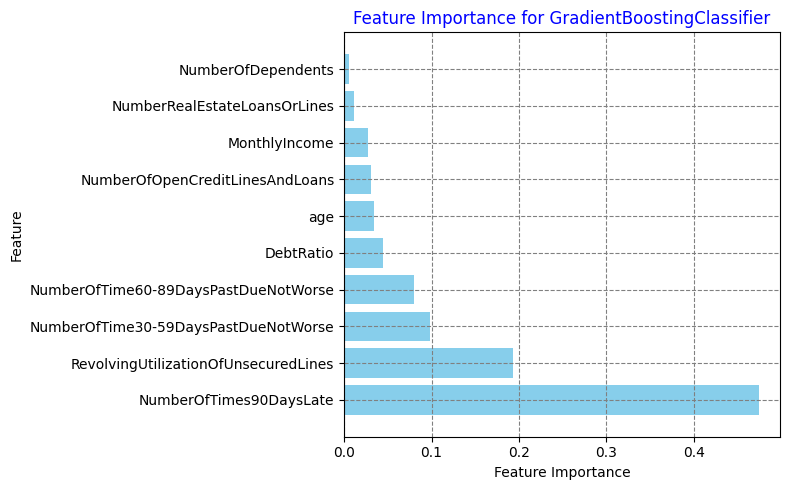

In [42]:
plot_feature_importances(clf, X_train)

<h4 style=color:red>XG Boost</h4>

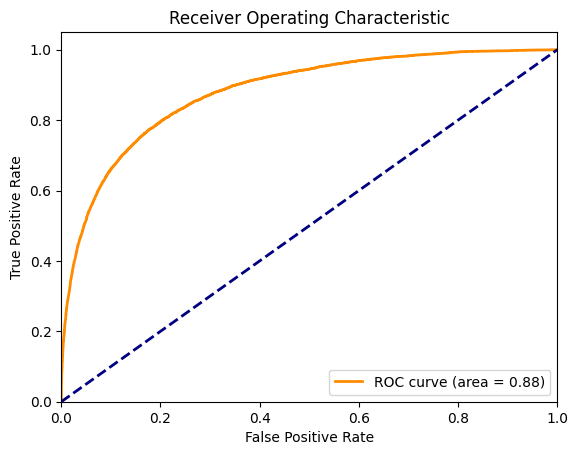

AUC Score: 0.8798426


In [43]:
from xgboost import XGBClassifier
# In sample.
clf = XGBClassifier(random_state=42, n_estimators=200, learning_rate=0.05, max_depth=5)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_train)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

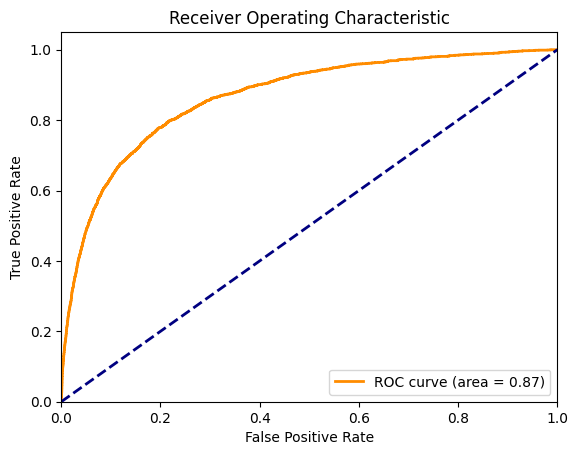

AUC Score: 0.8655986


In [44]:
preds = clf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

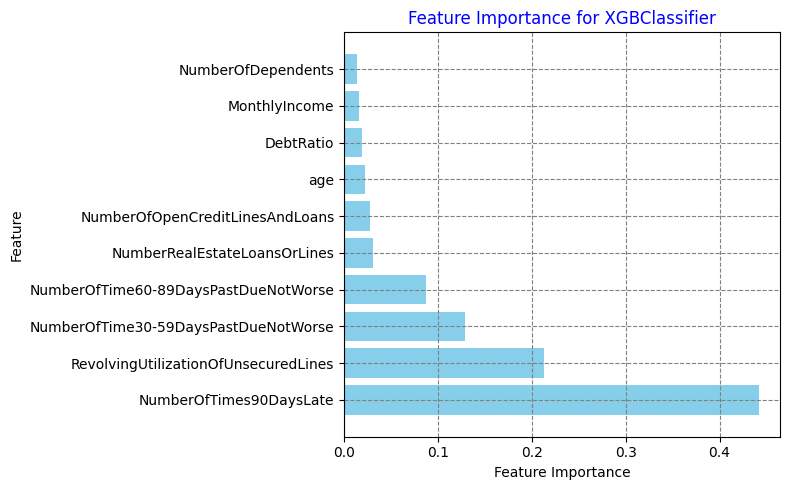

In [45]:
plot_feature_importances(clf, X_train)

<h4 style=color:red>Stacking</h4>

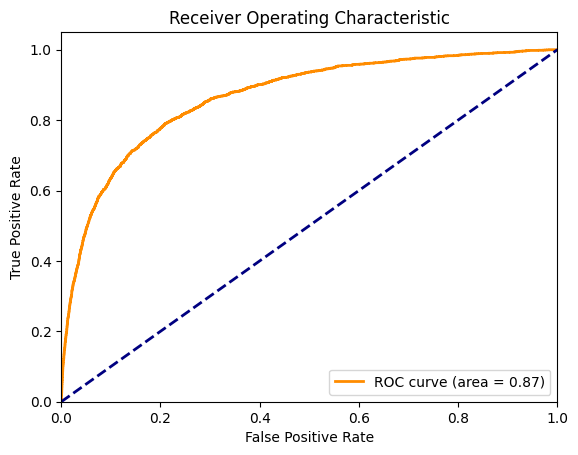

AUC Score: 0.8655204


In [49]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define Stacking function
def Stacking(model, train, y, test, n_fold):
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    train_pred = cross_val_predict(model, train, y, cv=folds, method='predict_proba')
    model.fit(train, y)
    test_pred = model.predict_proba(test)
    return test_pred, train_pred

# Define base models
model1 = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=1))
])

model2 = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=123))
])

# Hyperparameter tuning for model2
param_grid = {
    'xgb__n_estimators': [100, 150, 200],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_model2 = grid_search.best_estimator_

# Get predictions from base models
test_pred1, train_pred1 = Stacking(model=model1, n_fold=10, train=X_train, test=X_test, y=y_train)
test_pred2, train_pred2 = Stacking(model=best_model2, n_fold=10, train=X_train, test=X_test, y=y_train)

# Concatenate predictions
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)

# Train meta-model
meta_model = LogisticRegression(random_state=123)
meta_model.fit(df, y_train)

# Evaluate meta-model
clf_scores_proba = meta_model.predict_proba(df_test)
clf_preds = clf_scores_proba[:, 1]
fpr, tpr, threshold = roc_curve(y_test, clf_preds)
roc_auc = roc_auc_score(y_test, clf_preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score: {roc_auc:.7f}")

<h4 style=color:red>Testing Data</h4>

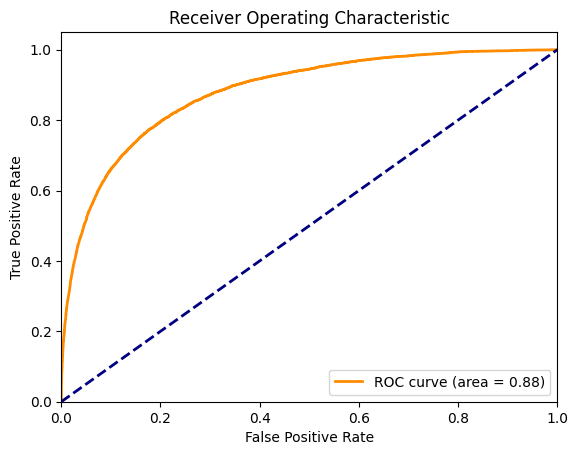

AUC Score (train): 0.8798426


In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

clf = XGBClassifier(random_state=42, n_estimators=200, learning_rate=0.05, max_depth=5)
clf.fit(X_train, y_train)

clf_scores_proba = clf.predict_proba(X_train)
clf_preds = clf_scores_proba[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, clf_preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

print(f"AUC Score (train): {roc_auc:.7f}")

test_preds = clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({'Id': X_test.index, 'Predicted': test_preds})
submission.to_csv('/kaggle/working/submission.csv', index=False)